## Spatial trend maps 

In [1]:
from pathlib import Path 
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import datetime
import pandas as pd 
import cartopy.crs as ccrs 
import cmocean
mpl.style.use("../ccic.mplstyle") 

path = Path('/scratch/ccic_record/data')
mask = xr.open_dataset(path / 'mask_24.nc')
mask = mask.mask.astype(int)

### Read in datasets

In [2]:
# MODIS 
modis = xr.open_dataset(path / 'processed' / 'modis_global_distribution_cf_tiwp_by_year.nc')
modis_tiwp = modis.TIWP_global_distribution_unmasked / 1000

# PATMOS-x 
patmos_ds = xr.open_dataset(path / 'PATMOS-x' / 'means' / 'PATMOS-x_timeseries198108-202106_notebook_results.nc')
mask_patmos = mask.interp(coords = {'longitude': patmos_ds.longitude.values, 'latitude': patmos_ds.latitude.values}, method = 'linear')
patmos_tiwp = patmos_ds.tiwp_yearly_mean / 1000

# ERA5 
era = xr.open_dataset(path / 'ERA5' / 'era5_tcsw_tciw_tcc_1980_2023_annualmeans.nc')
era_tiwp = era.tcsw[:,0,:,:]  + era.tciw[:,0,:,:] 

# CCIC GridSat 
ccic = xr.open_dataset( path / 'ccic' / 'gridsat' / 'ccic_gridsat_annualmean.nc') 
ccic_tiwp = ccic.tiwp 

# CCIC CPCIR 
ccic_cpcir = xr.open_dataset(path / "processed" / "ccic_cpcir_tiwp_ca.nc")
ccic_cpcir_tiwp = ccic_cpcir.tiwp_yearly

# ISCCP 
isccp = path / 'processed' / 'isccp_tiwp_annual.nc'
isccp_ds = xr.open_dataset(isccp) 
isccp_tiwp = isccp_ds.tiwp

### Common time period for trend 

In [3]:
# restrict to common time period 2003 - 2021
minyear = 2003
maxyear = 2021 

ccic_tiwp_cropped = ccic_tiwp.where((ccic_tiwp.month.dt.year >= minyear) & (ccic_tiwp.month.dt.year <= maxyear), drop = True)
ccic_cpcir_tiwp_cropped = ccic_cpcir_tiwp.where((ccic_cpcir_tiwp.year >= minyear) & (ccic_cpcir_tiwp.year <= maxyear), drop = True)
era_tiwp_cropped = era_tiwp.where((era_tiwp.time.dt.year >= minyear ) & (era_tiwp.time.dt.year <= maxyear), drop = True) 
modis_tiwp_cropped = modis_tiwp.where((modis_tiwp.year >= minyear ) & (modis_tiwp.year <= maxyear), drop = True)
patmos_tiwp_cropped = patmos_tiwp.where((patmos_tiwp.year >= minyear) & (patmos_tiwp.year <= maxyear), drop = True) 
isccp_tiwp_cropped = isccp_tiwp.where(( isccp_tiwp.time.dt.year >= minyear) & ( isccp_tiwp.time.dt.year <= maxyear), drop = True)

In [203]:
def get_spatial_trend(data, timevar, normalize = False ): 
    poly = data.polyfit(timevar, 1, skipna = True ) # fit polynomial of degree 1
    slope = poly.polyfit_coefficients.sel(degree=1).values * 10 # per decade
    if normalize is True: 
        slope = slope / np.maximum(data.mean(timevar).data, 0.01 * np.nanmean(data.data))
    return slope 

In [5]:
print(ccic_tiwp_cropped.shape, modis_tiwp_cropped.shape, patmos_tiwp_cropped.shape, era_tiwp_cropped.shape, isccp_tiwp_cropped.shape) 
print(ccic_tiwp_cropped.dims, modis_tiwp_cropped.dims, patmos_tiwp_cropped.dims, era_tiwp_cropped.dims, isccp_tiwp_cropped.dims)

(19, 2000, 5143) (180, 360, 19) (19, 1800, 3600) (19, 721, 1440) (15, 180, 360)
('month', 'latitude', 'longitude') ('lat', 'lon', 'year') ('year', 'latitude', 'longitude') ('time', 'latitude', 'longitude') ('time', 'latitude', 'longitude')


### Calculate trends per decade

In [118]:
# get time dimension right for scaling 
ccic_tiwp = ccic_tiwp.swap_dims({'month': 'year'})
era_tiwp = era_tiwp.swap_dims({'time': 'year'})

ValueError: cannot swap from dimension 'month' because it is not one of the dimensions of this dataset ('year', 'longitude', 'latitude')

In [204]:
# get slopes for FULL RECORD 
normalize = True
slope_ccic = get_spatial_trend(ccic_tiwp, 'year', normalize = normalize)
slope_era = get_spatial_trend(era_tiwp, 'year', normalize = normalize)
slope_patmos = get_spatial_trend(patmos_tiwp, 'year', normalize = normalize)
slope_modis = get_spatial_trend(modis_tiwp, 'year', normalize = normalize)

In [208]:
isccp_tiwp.coords['year'] = (('time'), isccp_tiwp.time.dt.year.data)
slope_isccp = get_spatial_trend(isccp_tiwp.copy().assign_coords({"time": isccp_tiwp.time.dt.year.data}), 'time', normalize = normalize)
slope_era = get_spatial_trend(era_tiwp, 'year', normalize = normalize)

In [231]:
era_tiwp.year

<xarray.DataArray 'year' (year: 44)> Size: 352B
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43])
Coordinates:
    time     (year) datetime64[ns] 352B 1980-06-16 1981-06-16 ... 2023-06-16
    expver   int32 4B 1
Dimensions without coordinates: year

In [222]:
slope_ccic_abs = get_spatial_trend(ccic_tiwp, "year", normalize=False)
slope_era_abs = get_spatial_trend(era_tiwp, 'year', normalize=False)

In [209]:
slope_ccic_cpcir = get_spatial_trend(ccic_cpcir_tiwp, 'year', normalize = normalize)

In [57]:
# get time dimension right for scaling 
years = np.arange(minyear, maxyear + 1 )
ccic_tiwp_cropped.coords['year'] = ('month', ), years
ccic_tiwp_cropped = ccic_tiwp_cropped.swap_dims({'month': 'year'})
era_tiwp_cropped.coords['year'] = ('time', ), years
era_tiwp_cropped = era_tiwp_cropped.swap_dims({'time': 'year'})
modis_tiwp_cropped.coords['year'] = ('year', ), years
patmos_tiwp_cropped.coords['year'] = ('year', ), years

ValueError: cannot add coordinates with new dimensions to a DataArray

In [12]:
ccic_cpcir_tiwp_cropped.coords['year'] = ('month', ), years
ccic_cpcir_tiwp_cropped = ccic_cpcir_tiwp_cropped.swap_dims({'month': 'year'})

ValueError: cannot add coordinates with new dimensions to a DataArray

In [205]:
# get slopes for OVERLAPPING TIME PERIOD 
slope_ccic_cropped = get_spatial_trend(ccic_tiwp_cropped, 'year', normalize=True)
slope_era_cropped = get_spatial_trend(era_tiwp_cropped, 'year', normalize=True)
slope_patmos_cropped = get_spatial_trend(patmos_tiwp_cropped, 'year', normalize=True)
slope_modis_cropped = get_spatial_trend(modis_tiwp_cropped, 'year', normalize=True)

In [210]:
slope_isccp_cropped = get_spatial_trend(isccp_tiwp_cropped.copy().assign_coords(time=isccp_tiwp_cropped.time.dt.year.data), 'time', normalize=True)

In [211]:
slope_ccic_cpcir_cropped = get_spatial_trend(ccic_cpcir_tiwp_cropped, 'year', normalize=True)

### Plot spatial trend maps 

In [ ]:
ax.contour(

In [186]:
cntr_styles

{np.float64(0.5): ':',
 np.float64(1.0): '.-',
 np.float64(1.5): '--',
 np.float64(2.0): '-'}

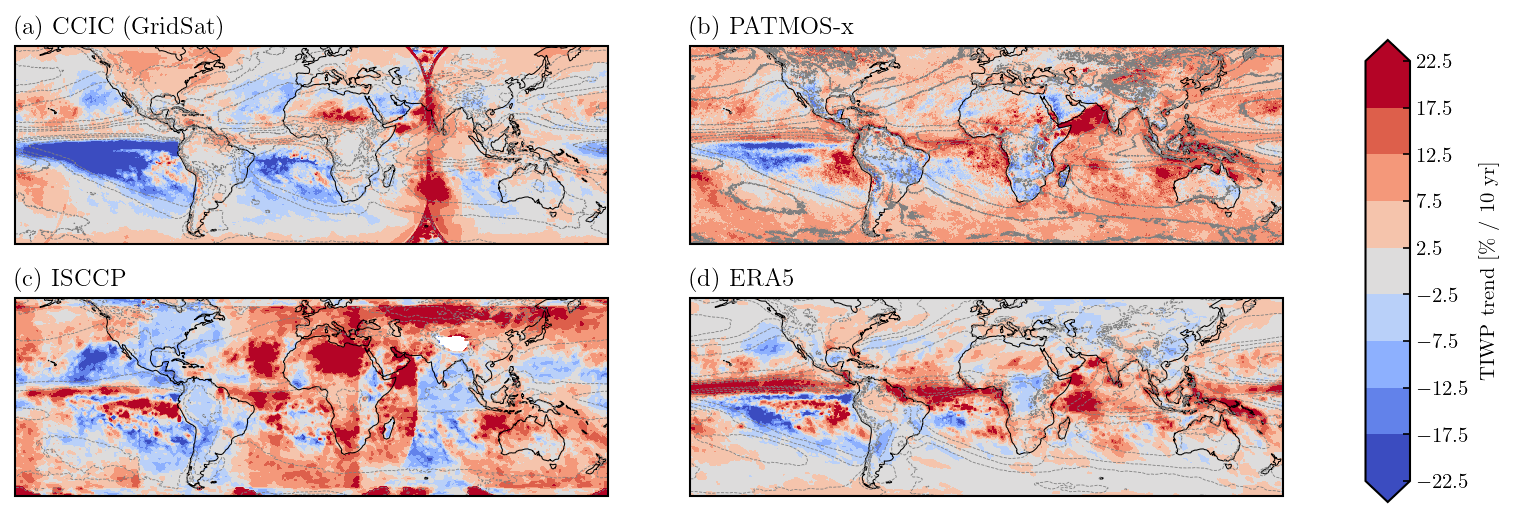

In [218]:
import cartopy.crs as ccrs
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from matplotlib import colormaps

fig = plt.figure(figsize=(12, 4))
n_row = 2
n_col = 2
gs = GridSpec(n_row, n_col + 1, width_ratios=[1.0] * n_col + [0.075])
norm = Normalize(-20, 20)
cmap = colormaps["coolwarm"]

results = {
    "CCIC (GridSat)": (ccic_tiwp.latitude, ccic_tiwp.longitude, slope_ccic, ccic_tiwp.mean("year")),
    "PATMOS-x": (patmos_tiwp.latitude, patmos_tiwp.longitude, slope_patmos, patmos_tiwp.mean("year")),
    "ISCCP": (isccp_tiwp.latitude, isccp_tiwp.longitude, slope_isccp, isccp_tiwp.mean("time")),
    "ERA5": (era_tiwp.latitude, era_tiwp.longitude, slope_era, era_tiwp.mean("year")),
}

for ind, (name, (lats, lons, res, tiwp)) in enumerate(results.items()):
    
    row_ind = ind // n_col
    col_ind = ind % n_col
    ax = fig.add_subplot(gs[row_ind, col_ind], projection=ccrs.PlateCarree())
    
    m = ax.contourf(lons, lats, 100 * res, norm=norm, cmap=cmap, levels=np.linspace(-22.5, 22.5, 10), extend="both")

    cntr_levels = np.linspace(0, 2, 5)[1:]
    cntr_styles = ["dotted", "dashdotted", "dashed", "solid"]
    ctrs = ax.contour(lons, lats, tiwp / tiwp.mean(), levels=cntr_levels, colors="grey", linestyles="--", linewidths=0.4)
    
    ax.set_ylim(-60, 60)
    ax.set_xlim(-180, 180)

    ax.set_title(f"({chr(ord('a') + ind)}) {name}")

    if col_ind > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Latitude [$^\circ$ N]")

    if row_ind < 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Longitude [$^\circ$ W]")

    ax.coastlines()
    ax.grid(True)

cax = fig.add_subplot(gs[:, -1])
plt.colorbar(m, cax=cax, label="TIWP trend [\% / 10 yr]")
plt.show()
fig.savefig("../figures/long_term_trends.png", bbox_inches="tight")

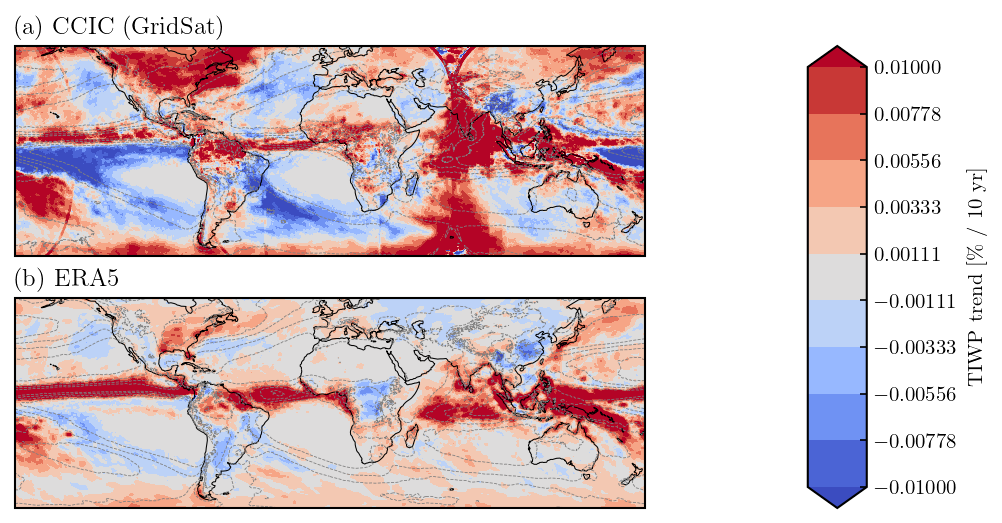

In [235]:
import cartopy.crs as ccrs
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from matplotlib import colormaps

fig = plt.figure(figsize=(8, 4))
n_row = 2
n_col = 1
gs = GridSpec(n_row, n_col + 1, width_ratios=[1.0] * n_col + [0.075])
norm = Normalize(-0.01, 0.01)
cmap = colormaps["coolwarm"]

results = {
    "CCIC (GridSat)": (ccic_tiwp.latitude, ccic_tiwp.longitude, slope_ccic_abs, ccic_tiwp.mean("year")),
    "ERA5": (era_tiwp.latitude, era_tiwp.longitude, slope_era_abs, era_tiwp.mean("year")),
}

for ind, (name, (lats, lons, res, tiwp)) in enumerate(results.items()):
    
    row_ind = ind // n_col
    col_ind = ind % n_col
    ax = fig.add_subplot(gs[row_ind, col_ind], projection=ccrs.PlateCarree())
    
    m = ax.contourf(lons, lats, res, norm=norm, cmap=cmap, levels=np.linspace(-0.01, 0.01, 10), extend="both")

    cntr_levels = np.linspace(0, 2, 5)[1:]
    cntr_styles = ["dotted", "dashdotted", "dashed", "solid"]
    ctrs = ax.contour(lons, lats, tiwp / tiwp.mean(), levels=cntr_levels, colors="grey", linestyles="--", linewidths=0.4)
    
    ax.set_ylim(-60, 60)
    ax.set_xlim(-180, 180)

    ax.set_title(f"({chr(ord('a') + ind)}) {name}")

    if col_ind > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Latitude [$^\circ$ N]")

    if row_ind < 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Longitude [$^\circ$ W]")

    ax.coastlines()
    ax.grid(True)

cax = fig.add_subplot(gs[:, -1])
plt.colorbar(m, cax=cax, label="TIWP trend [\% / 10 yr]")
plt.show()
fig.savefig("../figures/long_term_trends_abs.png", bbox_inches="tight")

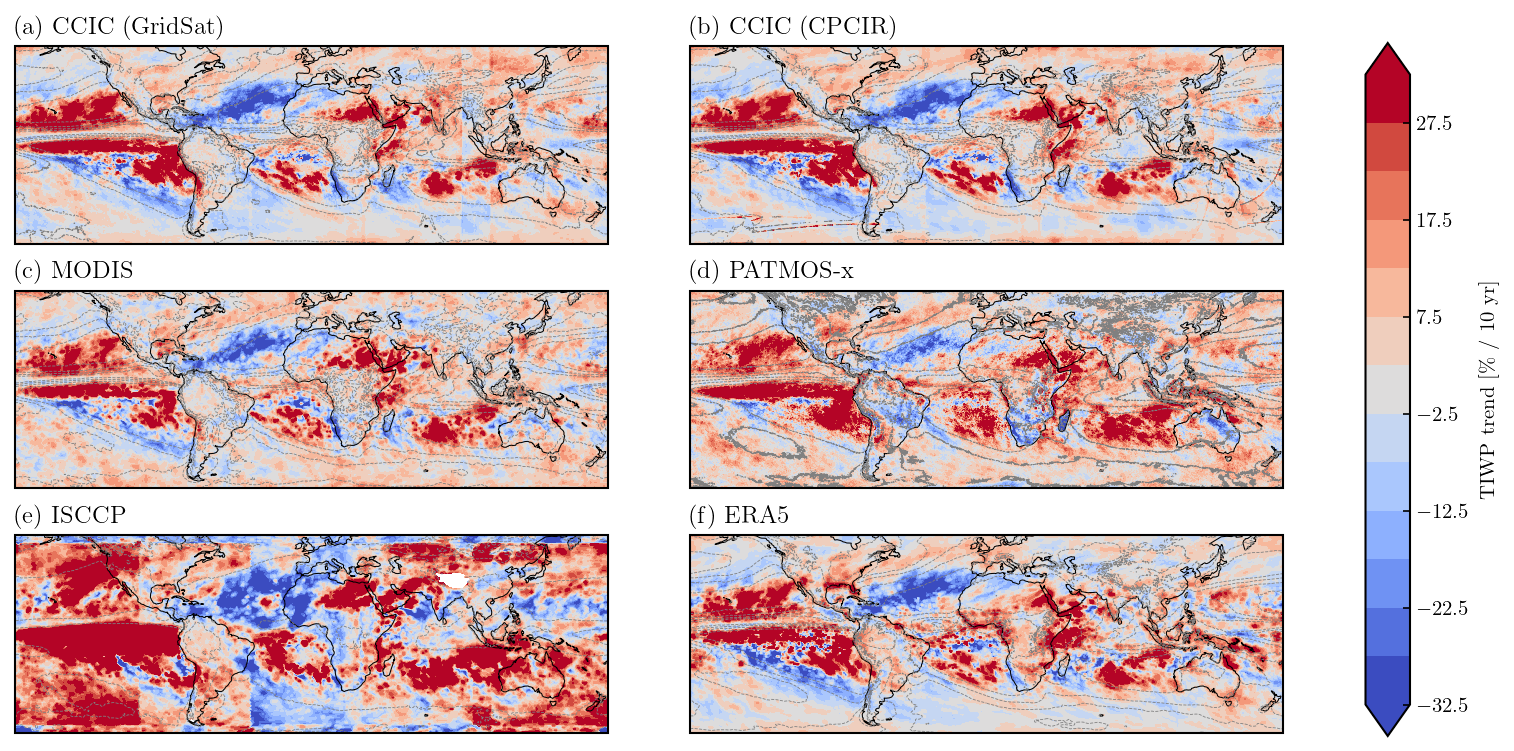

In [219]:
import cartopy.crs as ccrs
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from matplotlib import colormaps

fig = plt.figure(figsize=(12, 6))
n_row = 3
n_col = 2
gs = GridSpec(n_row, n_col + 1, width_ratios=[1.0] * n_col + [0.075])
norm = Normalize(-30, 30)
cmap = colormaps["coolwarm"]

results = {
    "CCIC (GridSat)": (ccic_tiwp.latitude, ccic_tiwp.longitude, slope_ccic_cropped, ccic_tiwp.mean("year")),
    "CCIC (CPCIR)": (ccic_cpcir_tiwp.latitude[::4], ccic_cpcir_tiwp.longitude[::4], slope_ccic_cpcir_cropped[::4, ::4], ccic_cpcir_tiwp.mean("year")[::4, ::4]),
    "MODIS": (modis_tiwp.lat, modis.lon, slope_modis_cropped[::-1], modis_tiwp.mean("year")[::-1]),
    "PATMOS-x": (patmos_tiwp.latitude, patmos_tiwp.longitude, slope_patmos_cropped, patmos_tiwp.mean("year")),
    "ISCCP": (isccp_tiwp.latitude, isccp_tiwp.longitude, slope_isccp_cropped, isccp_tiwp.mean("time")),
    "ERA5": (era_tiwp.latitude, era_tiwp.longitude, slope_era_cropped, era_tiwp.mean("year")),
}

for ind, (name, (lats, lons, res, tiwp)) in enumerate(results.items()):
    
    row_ind = ind // n_col
    col_ind = ind % n_col
    ax = fig.add_subplot(gs[row_ind, col_ind], projection=ccrs.PlateCarree())
    m = ax.contourf(lons, lats, 100 * res, norm=norm, cmap=cmap, levels=np.linspace(-32.5, 32.5, 14), extend="both")
    
    cntr_levels = np.linspace(0, 2, 5)[1:]
    cntr_styles = ["dotted", "dashdotted", "dashed", "solid"]
    ctrs = ax.contour(lons, lats, tiwp / tiwp.mean(), levels=np.linspace(0, 2, 5)[1:], colors="grey", linestyles="--", linewidths=0.4)
    
    ax.set_ylim(-60, 60)
    ax.set_xlim(-180, 180)

    ax.set_title(f"({chr(ord('a') + ind)}) {name}")

    if col_ind > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Latitude [$^\circ$ N]")

    if row_ind < 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Longitude [$^\circ$ W]")

    ax.coastlines(color="k")
    ax.grid(True)

cax = fig.add_subplot(gs[:, -1])
plt.colorbar(m, cax=cax, label="TIWP trend [\% / 10 yr]")
fig.savefig("../figures/matched_trends.png", bbox_inches="tight")

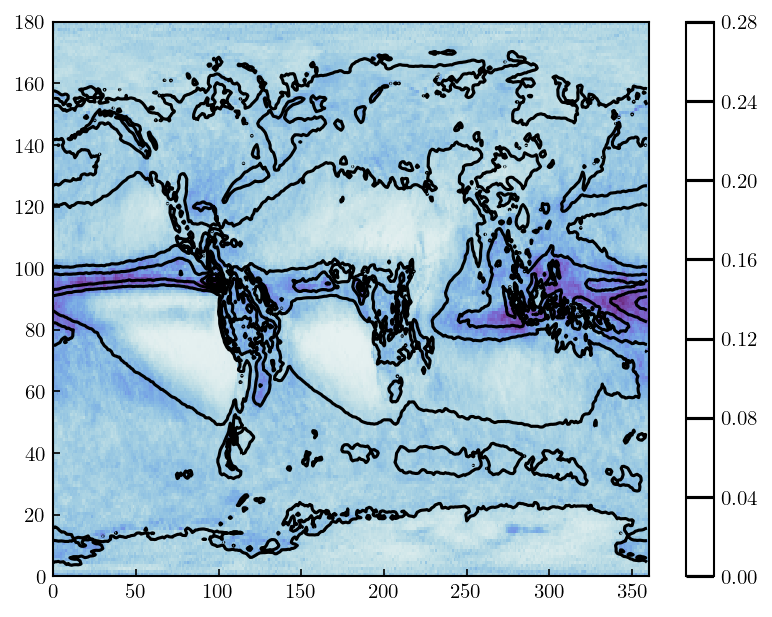

In [164]:
plt.pcolormesh(modis_tiwp.std("year")[::-1])
plt.contour(modis_tiwp.mean('year')[::-1], colors="k")
plt.colorbar()

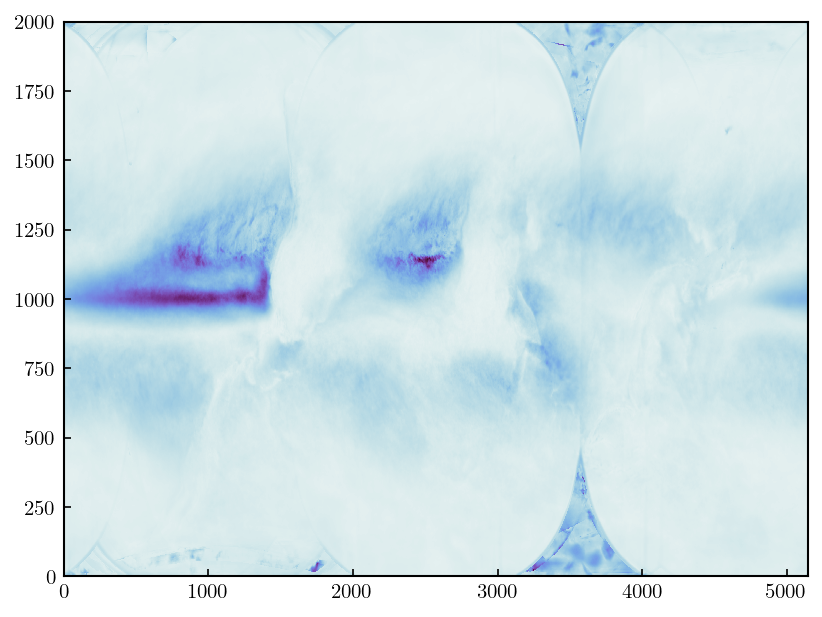

In [154]:
plt.pcolormesh(ccic_tiwp.std("year") / ccic_tiwp.mean("year"))

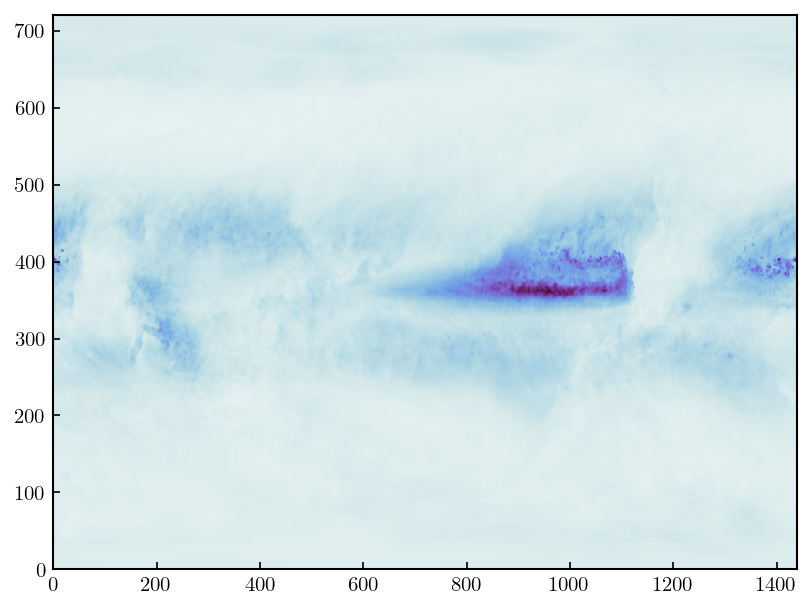

In [160]:
plt.pcolormesh(era_tiwp.std("year") / era_tiwp.mean("year"))